# stock analysis tool

this python script analyzes historical stock data using the yahoo finance api `yfinance`.
it downloads ohlcv data for a selected ticker, calculates technical indicators (daily returns and a simple moving average), saves results to csv and png files, and prints a statistical summary.

**author:** monika burnejko | 2025

### setup

imports and environment configuration

In [42]:
from dataclasses import dataclass
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

### configuration class for stock analysis parameters

**attributes:**

- ticker: stock ticker symbol (default: 'AMZN')
- period: historical data period (default: '5y')
- interval: data interval/frequency (default: '1d')
- sma_window: simple moving average window size (default: 20)
- out_dir: output directory for saved files (default: Path('stock_data'))
- show_plots: whether to display plots in notebook (default: True)

values are sensible defaults for immediate use

In [45]:
@dataclass
class Config:
# stock ticker symbol and data range
    ticker: str = 'AMZN'
    period: str = '5y'      # e.g., '1y', '2y', '5y', 'ytd'
    interval: str = '1d'    # e.g., '1d', '1wk', '1mo'
# indicators and output
    sma_window: int = 20
    out_dir: Path = Path('stock_data')
    show_plots: bool = True
 
    def ensure_out_dir(self) -> None:
        """ create output directory if it doesn't exist """
        self.out_dir.mkdir(parents=True, exist_ok=True)

### data fetching

**parameters:**

- ticker: stock ticker symbol (e.g., 'AAPL', 'TSLA', 'INTC')
- period: time period - valid values: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
- interval: data interval - valid values: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

**returns:**

- pd.DataFrame: DataFrame with ohlcv data indexed by date, containing columns:
    - Open: opening price
    - High: highest price
    - Low: lowest price
    - Close: closing price
    - Adj Close: adjusted closing price
    - Volume: trading volume

**raises:**

- RuntimeError: if no data found for the ticker or if download fails

In [48]:
def fetch_prices(ticker: str, period: str, interval: str) -> pd.DataFrame:
    """ fetch historical stock price data from yahoo finance """
    
    try:
        ## group_by='column' ensures a flat column index for recent yfinance
        df = yf.download(ticker, period=period, interval=interval,
                         auto_adjust=False, progress=False, group_by='column')
        if df.empty:
            raise RuntimeError(f'No data found for ticker {ticker}')
            
        # drop all-nan rows and set a clean index name
        df = df.dropna(how='all')
        if df.empty:
            raise RuntimeError(f'All data was NaN for ticker {ticker}')
        df.index.name = 'Date'
        return df
    except Exception as e:
        raise RuntimeError(f'Failed to fetch data for {ticker}: {e}')

### metrics

**parameters**:

- df: price dataframe with at least 'Close' and 'Adj Close' columns
- sma_window: window size (number of periods) for simple moving average calculation (e.g., 20, 50, 200)

**returns:**

- pd.DataFrame: copy of input dataframe with additional columns:
    - return_daily: daily percentage returns
    - SMA_{sma_window}: simple moving average

In [51]:
def add_metrics(df: pd.DataFrame, sma_window: int) -> pd.DataFrame:
    """ add technical indicators and metrics to the price dataframe """
 
    out = df.copy() # work on a copy to avoid mutating the original
    close = out['Adj Close'].fillna(out['Close'])
    
    # daily percentage change
    out['return_daily'] = close.pct_change()
    
    # simple moving average
    out[f'SMA_{sma_window}'] = close.rolling(sma_window).mean()
    return out

### csv file

**parameters:**
- df: DataFrame to save
- ticker: stock ticker symbol (used in filename)
- cfg: configuration object containing output directory path

**returns:**
- path: full path to the saved csv file

In [54]:
def save_csv(df: pd.DataFrame, ticker: str, cfg: Config) -> Path:
    """ save the dataframe to a csv file in the configured output directory """ 
 
    cfg.ensure_out_dir()
    path = cfg.out_dir / f'{ticker}.csv'
    df.to_csv(path)
    return path

### visualization

**parameters:**

- df: price dataframe containing 'Close', 'Adj Close', and sma columns
- ticker: stock ticker symbol (used in title and filename)
- sma_window: sma window size (used in legend)
- cfg: configuration object containing:
    - out_dir: directory to save the plot
    - show_plots: whether to display the plot

**returns:**

- path: full path to the saved png file

**note:**

- the plot is saved with 150 dpi resolution
- grid is displayed with 0.3 alpha (30%) for better readability
- if cfg.show_plots is True, the plot is displayed inline

In [57]:
def plot_price_sma(df: pd.DataFrame, ticker: str, sma_window: int, cfg: Config) -> Path:
    """ generate and save a price chart with simple moving average overlay """
  
    cfg.ensure_out_dir()
    close = df['Adj Close'].fillna(df['Close'])

    # render a line chart for price and sma
    plt.figure(figsize=(10, 5))
    plt.plot(close.index, close.values, label='Price', linewidth=1.5)
    plt.plot(df.index, df[f'SMA_{sma_window}'], label=f'SMA {sma_window}', alpha=0.7)
    plt.title(f'{ticker} - Price & SMA')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # save the plot as a png file and optionally displayed in the notebook
    out_path = cfg.out_dir / f'{ticker}_price_sma.png'
    plt.savefig(out_path, dpi=150)
    if cfg.show_plots:
        plt.show()
    plt.close()
    return out_path

### summary

**parameters:**

- df: price dataframe with 'Close', 'Adj Close', and 'return_daily' columns

**returns:**

- pd.DataFrame: single-column dataframe with summary statistics as rows:
    - Rows: number of data points
    - Start Date: first date in dataset (YYYY-MM-DD)
    - End Date: last date in dataset (YYYY-MM-DD)
    - Start Price: price at beginning of period
    - End Price: price at end of period
    - Total Return (%): overall percentage return
    - Daily Return Mean (%): average daily return
    - Daily Return Std (%): daily return volatility
    - Min Price: lowest price in period
    - Max Price: highest price in period

**note:**
- all percentage values are rounded to 2 decimal places

In [60]:
def summarize(df: pd.DataFrame) -> pd.DataFrame:
    """ generate statistical summary of stock price data """ 
    
    close = df.get('Adj Close', df['Close']).squeeze()
    returns = df['return_daily'].dropna()

    # calculates key statistics including: dataset size, date range, price range, total return over the period, daily return statistics
    stats = {
        'Rows': len(df),
        'Start Date': df.index[0].strftime('%Y-%m-%d'),
        'End Date': df.index[-1].strftime('%Y-%m-%d'),
        'Start Price': float(close.iloc[0]),
        'End Price': float(close.iloc[-1]),
        'Total Return (%)': float((close.iloc[-1] / close.iloc[0] - 1) * 100),
        'Daily Return Mean (%)': float(returns.mean() * 100),
        'Daily Return Std (%)': float(returns.std() * 100),
        'Min Price': float(close.min()),
        'Max Price': float(close.max()),
    }

    df_out = pd.DataFrame([stats]).T.rename(columns={0: 'Value'})
    nums = pd.to_numeric(df_out['Value'], errors='coerce')
    df_out['Value'] = df_out['Value'].where(nums.isna(), nums.round(2))

    return df_out

### full analysis pipeline

run the full workflow: 

1. fetches historical price data
2. calculates technical indicators
3. saves data to csv
4. generates and saves price chart
5.  computes and displays summary statistics

**parameters:**

- cfg: configuration object specifying:
    - ticker: stock symbol to analyze
    - period: historical period to fetch
    - interval: data frequency
    - sma_window: moving average window size
    - out_dir: directory for output files
    - show_plots: whether to display plots

**returns:**

- tuple: (df, stats) where:
    - df (pd.DataFrame): price data with calculated metrics
    - stats (pd.DataFrame): summary statistics

**raises:**

- RuntimeError: if data fetch fails or no data is available

**note:**

- uses display() function to show statistics table in notebook

In [63]:
def run_analysis(cfg: Config):
    """ execute complete stock analysis workflow """ 
 
    print(f'[INFO] Analyzing {cfg.ticker} | Period: {cfg.period} | Interval: {cfg.interval}')
    df = fetch_prices(cfg.ticker, cfg.period, cfg.interval)
    df = add_metrics(df, cfg.sma_window)
    csv_path = save_csv(df, cfg.ticker, cfg)
    png_path = plot_price_sma(df, cfg.ticker, cfg.sma_window, cfg)
    stats = summarize(df)
    print(f'[OK] Saved: {csv_path}')
    print(f'[OK] Saved: {png_path}')
    display(stats)  
    return df, stats

### examples

**example 1: using default parameters**

[INFO] Analyzing AMZN | Period: 5y | Interval: 1d


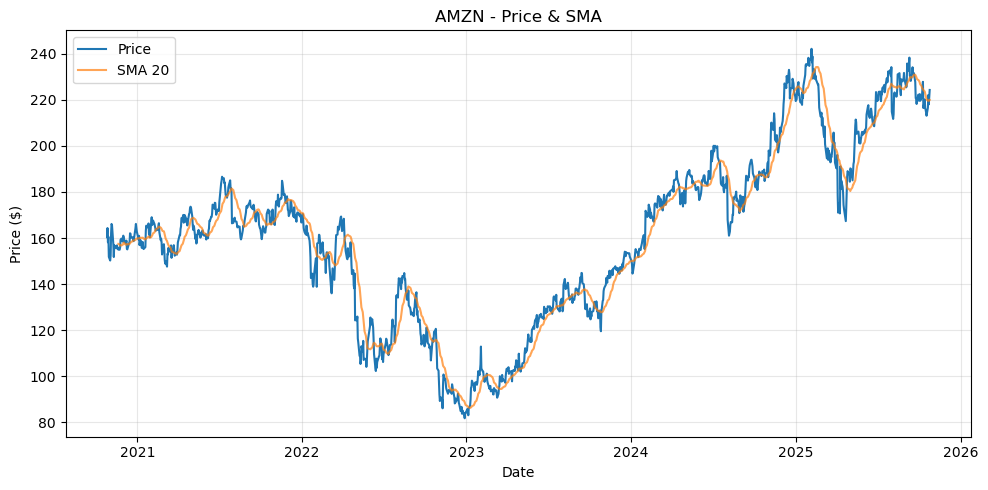

[OK] Saved: stock_data/AMZN.csv
[OK] Saved: stock_data/AMZN_price_sma.png


,Value
Rows,1256.0
Start Date,2020-10-26
End Date,2025-10-24
Start Price,160.35
End Price,224.21
Total Return (%),39.82
Daily Return Mean (%),0.05
Daily Return Std (%),2.21
Min Price,81.82
Max Price,242.06


In [67]:
cfg = Config()
df, stats = run_analysis(cfg)

**example 2: overriding all parameters**

[INFO] Analyzing TSLA | Period: 5y | Interval: 1wk


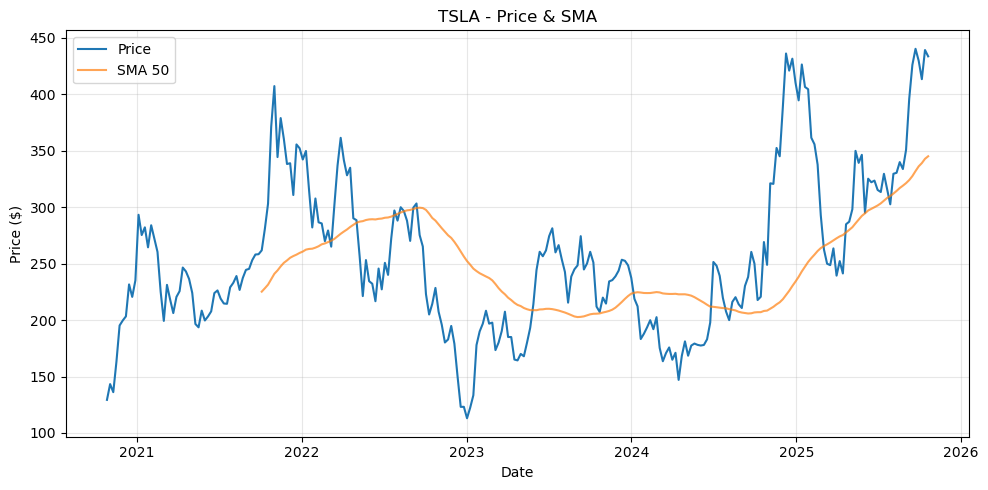

[OK] Saved: tesla_data/TSLA.csv
[OK] Saved: tesla_data/TSLA_price_sma.png


,Value
Rows,261.0
Start Date,2020-10-26
End Date,2025-10-20
Start Price,129.35
End Price,433.72
Total Return (%),235.32
Daily Return Mean (%),0.81
Daily Return Std (%),8.42
Min Price,113.06
Max Price,440.4


Price,Adj Close,Close,High,Low,Open,Volume,return_daily,SMA_50
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,,
Date,,,,,,,,
2020-10-26,129.346664,129.346664,143.500000,126.370003,137.210007,424631100,NaN,NaN
2020-11-02,143.316666,143.316666,146.666672,130.766663,131.333328,436909200,0.108004,NaN
2020-11-09,136.166672,136.166672,150.833328,132.009995,146.500000,366303300,-0.049889,NaN
2020-11-16,163.203339,163.203339,169.536667,134.696671,136.309998,784374300,0.198556,NaN
2020-11-23,195.253326,195.253326,199.593338,167.263336,167.833328,571200300,0.196381,NaN


In [70]:
cfg = Config(
    ticker='TSLA',
    period='5y',
    interval='1wk',
    sma_window=50,
    out_dir=Path('tesla_data')
)
df, stats = run_analysis(cfg)

# preview the first rows of the downloaded and processed dataset
df.head()

**example 3: multi-stock analysis**

[INFO] Analyzing ORCL | Period: 2y | Interval: 1d


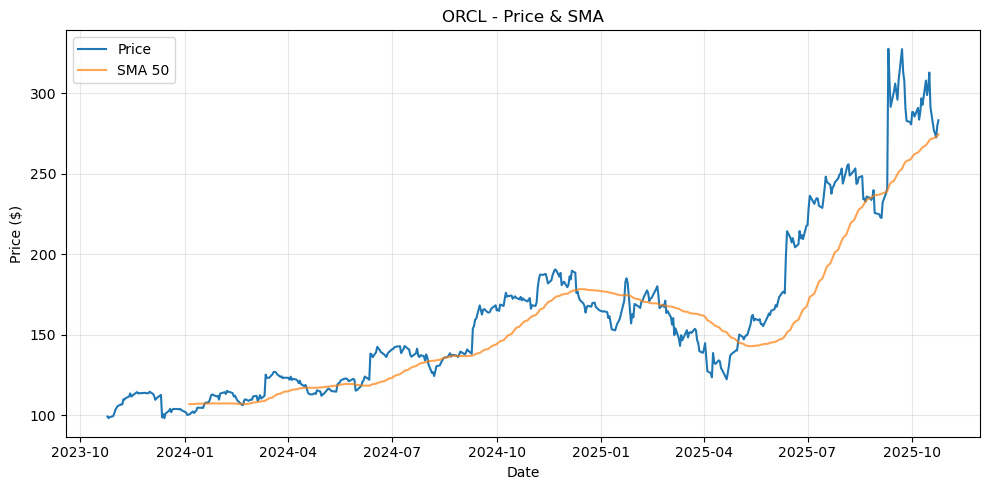

[OK] Saved: stock_data/ORCL.csv
[OK] Saved: stock_data/ORCL_price_sma.png


,Value
Rows,502.0
Start Date,2023-10-25
End Date,2025-10-24
Start Price,99.22
End Price,283.33
Total Return (%),185.56
Daily Return Mean (%),0.25
Daily Return Std (%),3.01
Min Price,98.12
Max Price,327.76


[INFO] Analyzing NVDA | Period: 2y | Interval: 1d


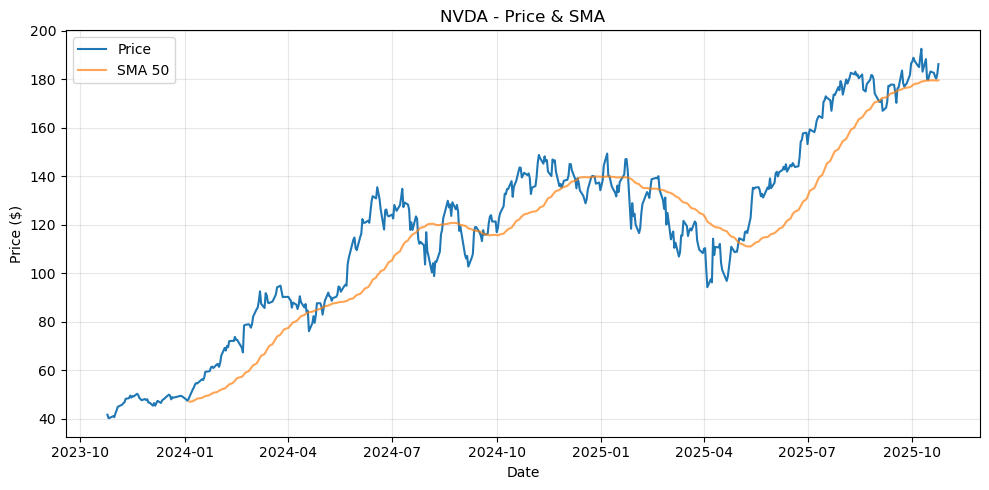

[OK] Saved: stock_data/NVDA.csv
[OK] Saved: stock_data/NVDA_price_sma.png


,Value
Rows,502.0
Start Date,2023-10-25
End Date,2025-10-24
Start Price,41.75
End Price,186.26
Total Return (%),346.08
Daily Return Mean (%),0.35
Daily Return Std (%),3.18
Min Price,40.3
Max Price,192.57


[INFO] Analyzing MSFT | Period: 2y | Interval: 1d


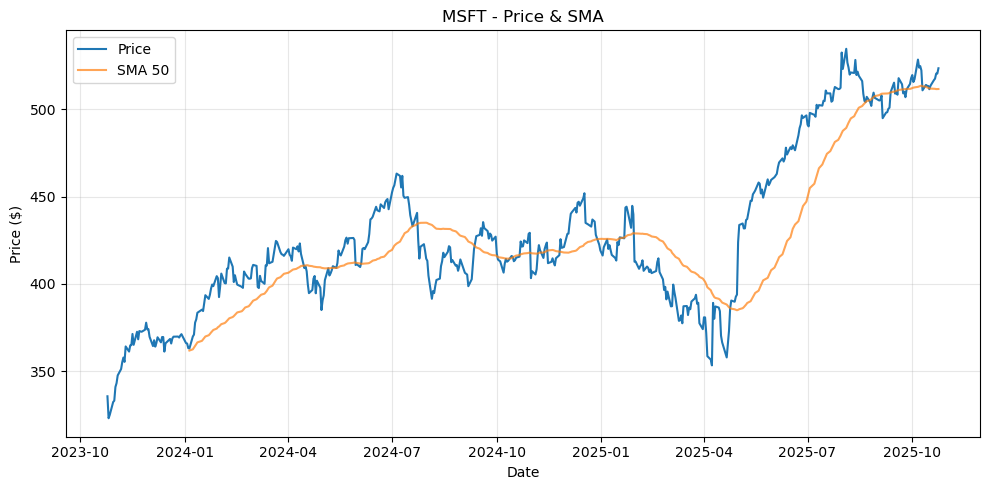

[OK] Saved: stock_data/MSFT.csv
[OK] Saved: stock_data/MSFT_price_sma.png


,Value
Rows,502.0
Start Date,2023-10-25
End Date,2025-10-24
Start Price,335.61
End Price,523.61
Total Return (%),56.02
Daily Return Mean (%),0.1
Daily Return Std (%),1.39
Min Price,323.02
Max Price,534.76


[INFO] Analyzing IBM | Period: 2y | Interval: 1d


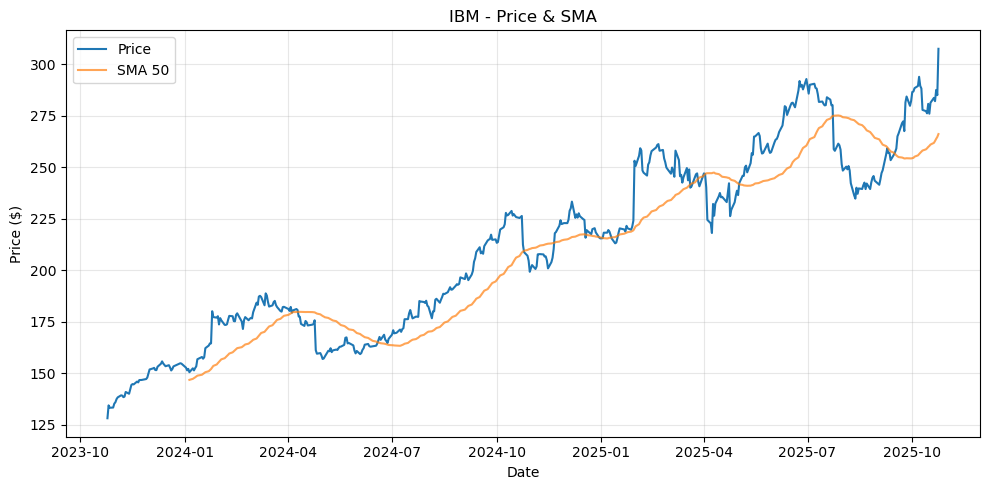

[OK] Saved: stock_data/IBM.csv
[OK] Saved: stock_data/IBM_price_sma.png


,Value
Rows,502.0
Start Date,2023-10-25
End Date,2025-10-24
Start Price,128.22
End Price,307.46
Total Return (%),139.79
Daily Return Mean (%),0.19
Daily Return Std (%),1.68
Min Price,128.22
Max Price,307.46


In [73]:
tickers = ['ORCL', 'NVDA', 'MSFT', 'IBM']

for ticker in tickers:
    cfg = Config(ticker=ticker, period='2y', sma_window=50)
    df, stats = run_analysis(cfg)